<hr style="height:2px;">

# Demo: Apply trained CARE model for isotropic reconstruction of Zebrafish retina

This notebook demonstrates applying a CARE model for an isotropic reconstruction task, assuming that training was already completed via [2_training.ipynb](2_training.ipynb).  
The trained model is assumed to be located in the folder `models` with the name `my_model`.

**Note:** The CARE model is here applied to the same image that the model was trained on.  
Of course, in practice one would typically use it to restore images that the model hasn't seen during training.

More documentation is available at http://csbdeep.bioimagecomputing.com/doc/.

In [27]:
from __future__ import print_function, unicode_literals, absolute_import, division
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from tifffile import imread
from scipy.ndimage import zoom
from csbdeep.utils import Path, download_and_extract_zip_file, plot_some
from csbdeep.io import save_tiff_imagej_compatible
from csbdeep.models import IsotropicCARE

<hr style="height:2px;">

# Download example data

The example data (also for testing) should have been downloaded in [1_datagen.ipynb](1_datagen.ipynb).  
Just in case, we will download it here again if it's not already present.

In [ ]:
download_and_extract_zip_file (
    url       = 'http://csbdeep.bioimagecomputing.com/example_data/retina.zip',
    targetdir = 'data',
)

<hr style="height:2px;">

# Raw 3D image stack with low axial resolution

We plot XY and XZ slices of the stack and define the image axes and subsampling factor, which will be needed later for prediction.

In [ ]:
x = imread('data/retina/cropped_farred_RFP_GFP_2109175_2color_sub_10.20.tif')

axes = 'ZCYX'
subsample = 10.2
print('image size         =', x.shape)
print('image axes         =', axes)
print('Z subsample factor =', subsample)

plt.figure(figsize=(16,15))
plot_some(np.moveaxis(x,1,-1)[[5,-5]],
          title_list=[['XY slice','XY slice']],
          pmin=2,pmax=99.8);

plt.figure(figsize=(16,15))
plot_some(np.moveaxis(np.moveaxis(x,1,-1)[:,[50,-50]],1,0),
          title_list=[['XZ slice','XZ slice']],
          pmin=2,pmax=99.8, aspect=subsample);

<hr style="height:2px;">

# Isotropic CARE model

Load trained model (located in base directory `models` with name `my_model`) from disk.  
The configuration was saved during training and is automatically loaded when `IsotropicCARE` is initialized with `config=None`.

In [4]:
model = IsotropicCARE(config=None, name='my_model', basedir='models')

Loading network weights from 'weights_best.h5'.


## Apply CARE network to raw image

Predict the reconstructed image, which can take a while. If there are memory issues, reduce the parameter `batch_size`.  

**Important:** You need to supply the subsampling factor, which must be the same as used during [training data generation](1_datagen.ipynb).

**Note**: *Out of memory* problems during `model.predict` can also indicate that the GPU is used by another process. In particular, shut down the training notebook before running the prediction (you may need to restart this notebook).

In [ ]:
%%time

restored = model.predict(x, axes, subsample)

print('input  size =', x.shape)
print('output size =', restored.shape)
print()

<hr style="height:2px;">

# Isotropically reconstructed image via CARE network

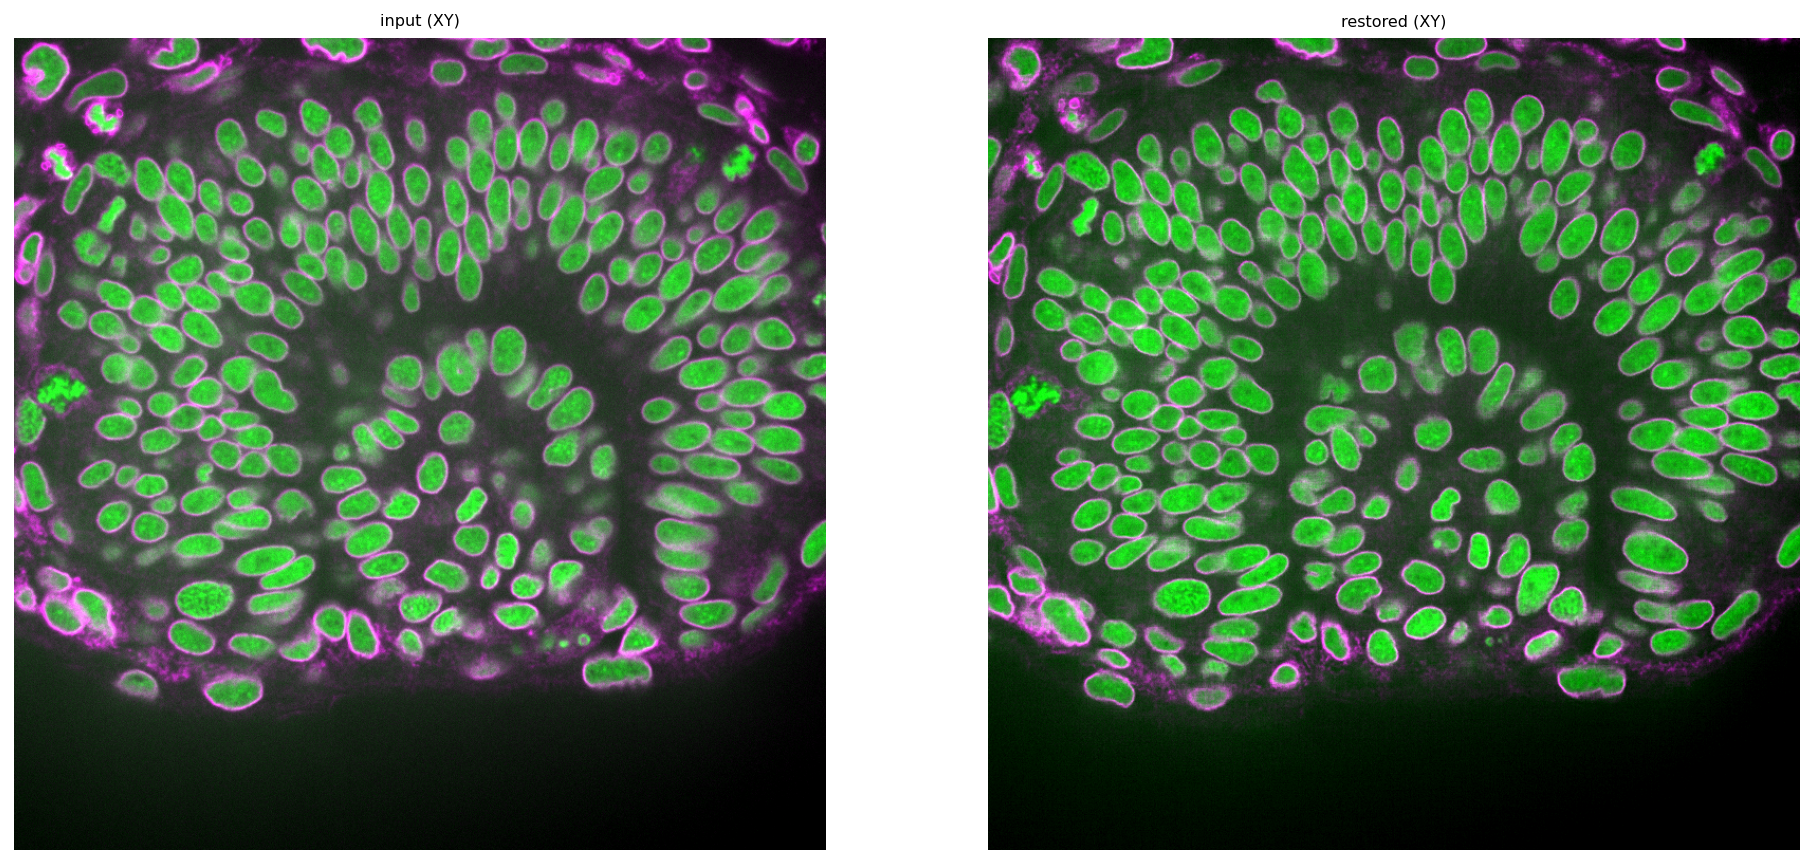

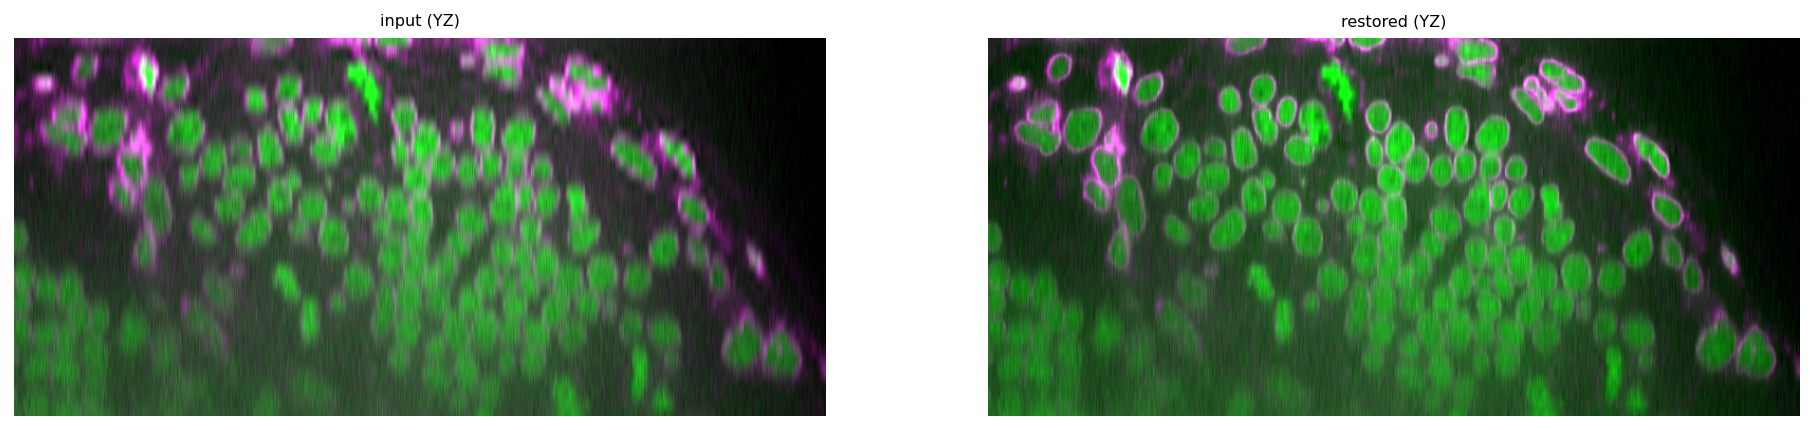

In [26]:
nz, nx = 50, 50


plt.figure(figsize=(16,15))
plot_some([np.moveaxis(x[int(nz/subsample)],0,-1), np.moveaxis(restored[nz], 0,-1)],
          title_list=[['input (XY)','restored (XY)']],
          pmin=2,pmax=99.8);

plt.figure(figsize=(16,15))
plot_some([np.moveaxis(zoom(x[...,nx], (subsample,1,1)), 1,-1), np.moveaxis(restored[...,nx], 1,-1)],
          title_list=[['input (YZ)','restored (YZ)']],
          pmin=2,pmax=99.8);


## Save reconstructed image

Save the reconstructed image stack as a ImageJ-compatible TIFF image, i.e. the image can be opened in ImageJ/Fiji with correct axes semantics.

In [ ]:
Path('results').mkdir(exist_ok=True)
save_tiff_imagej_compatible('results/%s_cropped_farred_RFP_GFP_2109175_2color_sub_10.20.tif' % model.name, restored, axes)